# DLProfile Example using Imagenet Application

## Set imports and neccessary environment variables

In [1]:
import pathlib
import os
import sys
import matplotlib.pyplot as plt
import warnings
import pprint
import pandas as pd
import tensorflow as tf
import ntpath
import numpy as np
import math

In [2]:
VANIDL_DIR="{}".format(pathlib.Path(os.getcwd()).parent.absolute())
sys.path.insert(0, VANIDL_DIR)
warnings.filterwarnings('ignore')

In [3]:
os.environ["DARSHAN_DIR"] = "/soft/perftools/darshan/darshan-3.1.8"
os.environ["VANIDL_DIR"] = VANIDL_DIR

### Formatting

In [4]:
pp = pprint.PrettyPrinter(indent=1)
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

## Create instrance of DL Profile and load the darshan file

In [5]:
from src.vanidl import VaniDL
profile = VaniDL()

In [6]:
#import shutil
#shutil.rmtree('/tmp/temp_analysis')

In [7]:
DATAPATH_INCLUDES = []
status = profile.Load("/home/dhari/darshan-logs/apps/imagenet/imagenet_run5_p8.darshan", data_paths_include=DATAPATH_INCLUDES)
if status:
    print("Darshan Trace loaded Successfully!")
else:
    print("Darshan Trace load Failed!")
    print(profile._error_str())

[============================================================] 100.0% 253778 of 253778 Parsing DXT File 
[============================================================] 100.0% 102290 of 102290 Parsing Darshan File 
Darshan Trace loaded Successfully!


## Use Profile object to analyze the darshan I/O trace.

### Verify if object works

The GetDXTAsDF() function enables users to perform analysis 

In [8]:
pd.set_option('display.max_colwidth', -1)
df = profile.GetDXTAsDF()
pp.pprint("Number of Files used in the application: {} files".format(df['Filename'].nunique()))

'Number of Files used in the application: 473 files'


### Collect the summary of the Application

In [9]:
summary = profile.GetSummary()
print("\n")
print(color.BOLD + "Data Access Summary (from Darshan):"+ color.END)
print("Total Job time\t\t\t:\t{:0.2f} seconds".format(summary['job_time']))
#FIXME: calculate time per rank and then take max across it.
print("Time spent in I/O\t\t:\t{:0.2f} seconds".format(summary['total_io_time']))
print("% Time spent in I/O\t\t:\t{:0.2f}%".format(float(summary['total_io_time'])*100/summary['job_time']))
print("Total Data Accessed\t\t:\t{:0.2f} GB".format(float(summary['total_io_bytes'])/1024.0/1024.0/1024.0))
print("Data Access Modules used\t:\t{}".format(summary['io_interface_used']))
print("Data Operations\t\t\t:\t{}".format(summary['io_operations_used']))
print("# of files used\t\t\t:\t{}".format(len(summary['files_used'])))
print("# of MPI Ranks\t\t\t:\t{:0.0f} ranks".format(summary['num_ranks']))
      
print(color.UNDERLINE + "Data Transfer size:"+ color.END)
print("\tMin,Max\t\t\t:\t{:0.0f} bytes and {:0.0f} bytes".format(summary['data_transfer_size']['min'],summary['data_transfer_size']['max']))
print("\tAverage\t\t\t:\t{:0.0f} bytes".format(summary['data_transfer_size']['mean']))
print("\tMedian\t\t\t:\t{:0.0f} bytes".format(summary['data_transfer_size']['median']))
      
print(color.UNDERLINE + "Data Transfer bandwidth: (per rank)"+ color.END)
print("\tMin,Max\t\t\t:\t{:0.0f} B/s and {:0.0f} MB/s".format(summary['data_transfer_bandwidth']['min'],summary['data_transfer_bandwidth']['max']/1024.0/1024.0))
print("\tAverage\t\t\t:\t{:0.0f} MB/s".format(summary['data_transfer_bandwidth']['mean']/1024.0/1024.0))
print("\tMedian\t\t\t:\t{:0.0f} MB/s".format(summary['data_transfer_bandwidth']['median']/1024.0/1024.0))
      
print(color.UNDERLINE + "Access Pattern:"+ color.END)
print("\tSequential\t\t:\t{:0.2f}%".format(float(summary['access_pattern']['sequential'])))
print("\tConsecutive\t\t:\t{:0.2f}%".format(float(summary['access_pattern']['consecutive'])))
#An I/O op issued at an offset greater than where the previous I/O op ended.
#An I/O op issued at the offset immediately after the end of the previous I/O

print("\n")
print(color.BOLD + "Files Summary:"+ color.END)
print("File Types\t\t\t:\t{}".format("tfrecord"))
print(color.UNDERLINE + "Dataset Size:"+ color.END)
print("\tTotal\t\t\t:\t{:0.3f} GB".format(float(summary['file_used_summary']['size']['total'])/1024.0/1024.0/1024.0))
print("\tMin,Max\t\t\t:\t{:0.3f} GB and {:0.3f} GB".format(float(summary['file_used_summary']['size']['min'])/1024.0/1024.0/1024.0,float(summary['file_used_summary']['size']['max'])/1024.0/1024.0/1024.0))
print("\tAverage\t\t\t:\t{:0.3f} GB".format(float(summary['file_used_summary']['size']['mean'])/1024.0/1024.0/1024.0))



Data Access Summary (from Darshan):
Total Job time			:	456.00 seconds
Time spent in I/O		:	31.27 seconds
% Time spent in I/O		:	6.86%
Total Data Accessed		:	60.54 GB
Data Access Modules used	:	['X_POSIX']
Data Operations			:	['read']
# of files used			:	473
# of MPI Ranks			:	8 ranks
Data Transfer size:
	Min,Max			:	0 bytes and 262144 bytes
	Average			:	261085 bytes
	Median			:	262144 bytes
Data Transfer bandwidth: (per rank)
	Min,Max			:	0 B/s and 2500 MB/s
	Average			:	1341 MB/s
	Median			:	1250 MB/s
Access Pattern:
	Sequential		:	99.74%
	Consecutive		:	99.74%


Files Summary:
File Types			:	tfrecord
Dataset Size:
	Total			:	132.085 GB
	Min,Max			:	0.000 GB and 0.151 GB
	Average			:	0.131 GB


In [10]:
pp.pprint("Job time : {} seconds".format(profile.GetJobTime()))

'Job time : 456.0 seconds'


In [11]:
pp.pprint("Time spent by application on I/O: {} seconds".format(profile.GetIOTime()))

'Time spent by application on I/O: 31.272650000023063 seconds'


### I/O time spent on each file

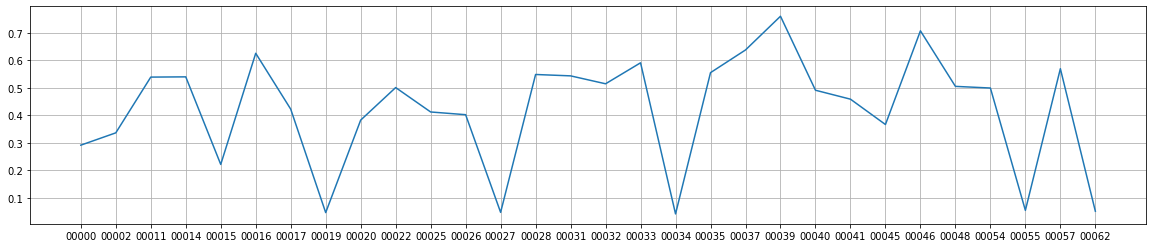

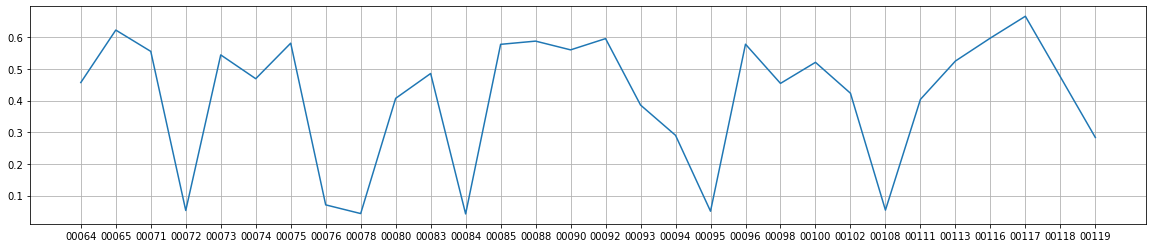

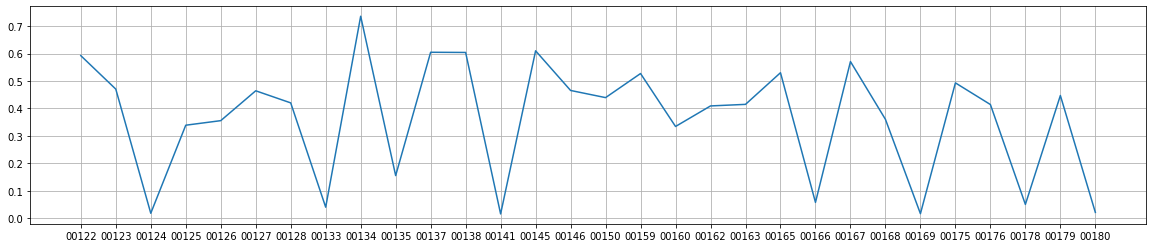

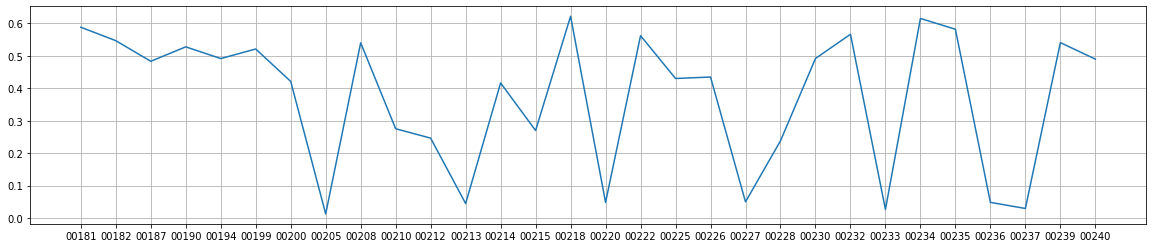

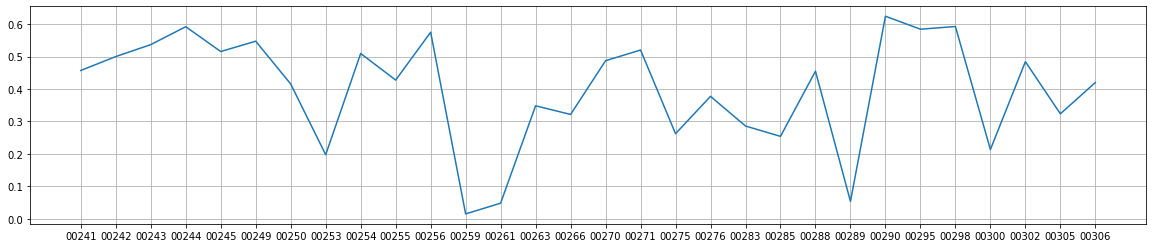

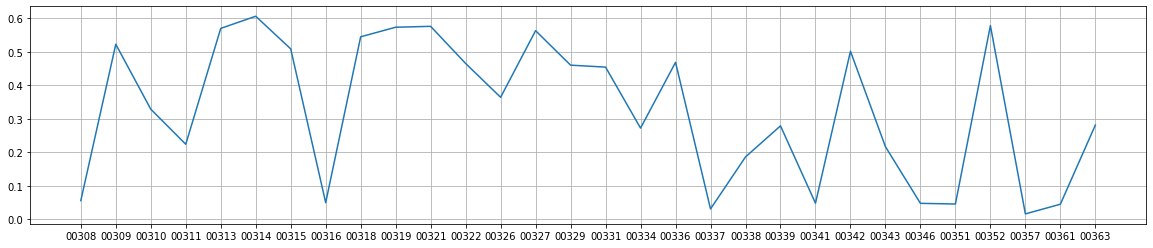

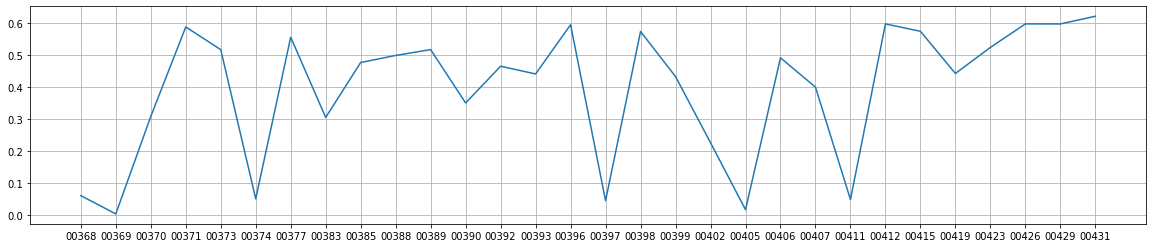

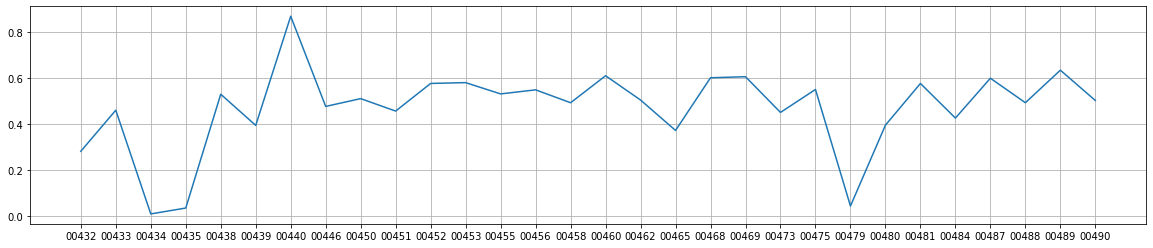

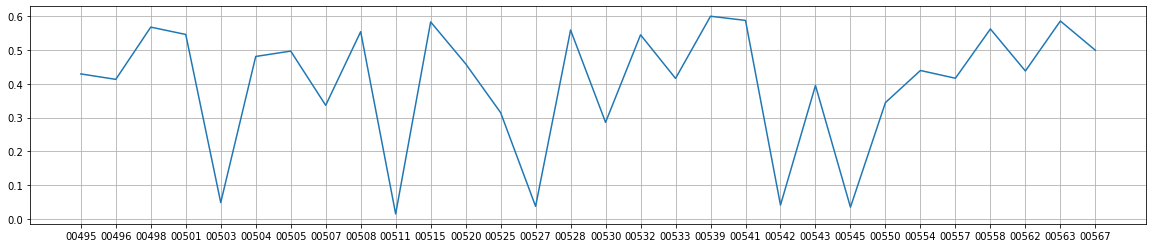

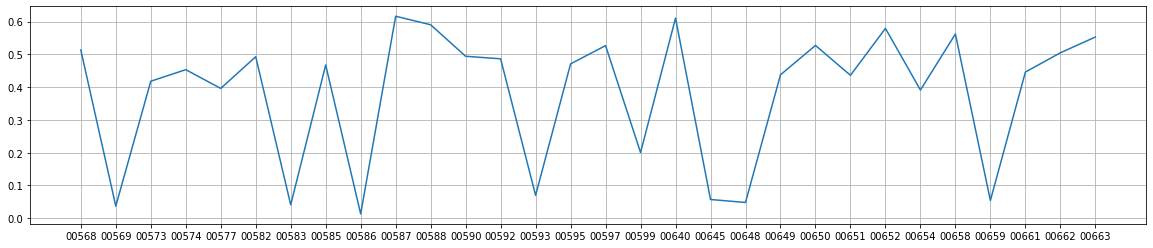

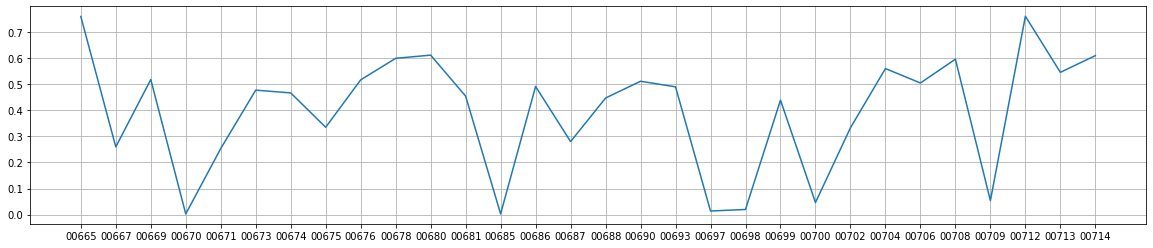

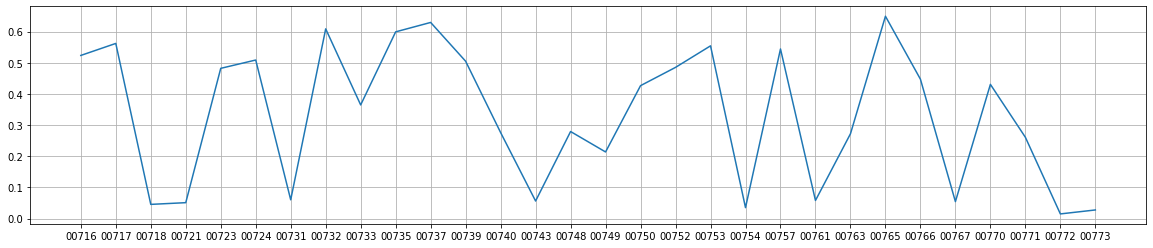

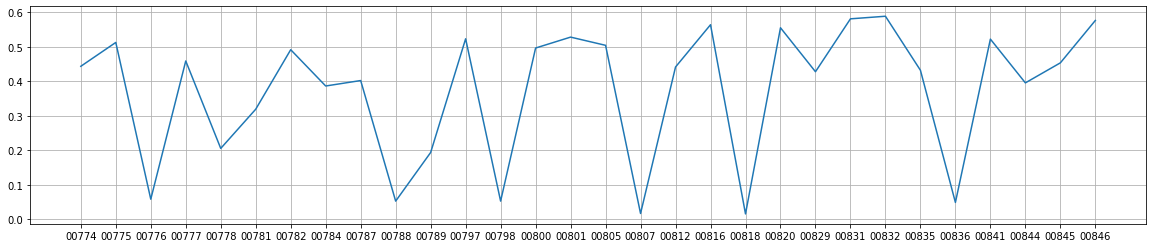

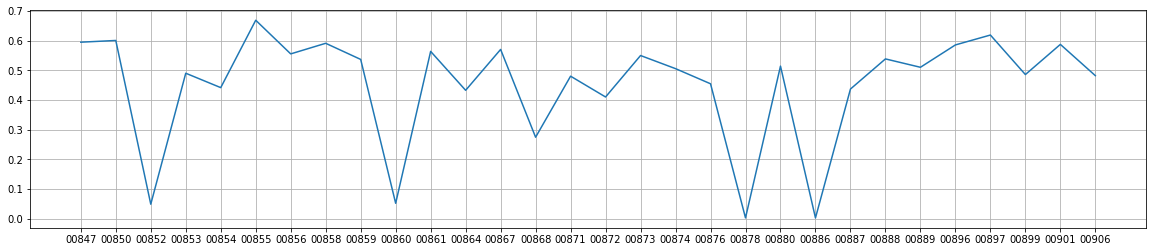

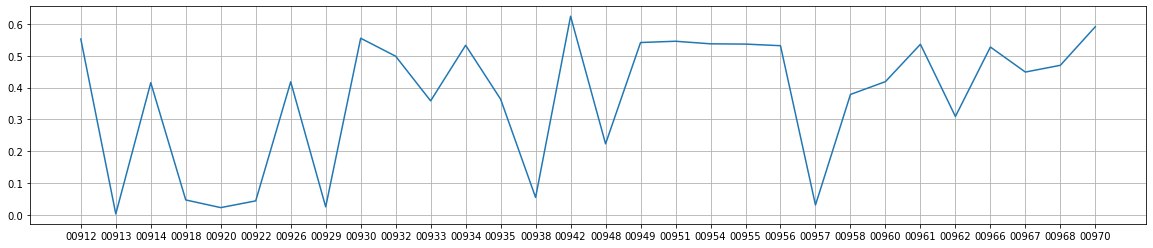

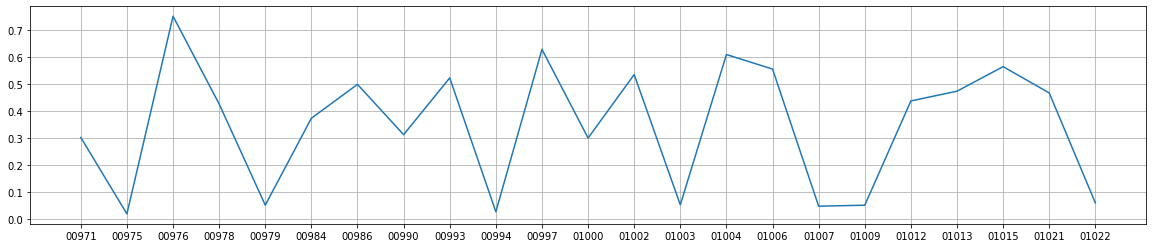

In [12]:
filename_series = []
time_series = []
for file in df['Filename'].unique():
    filename_series.append(os.path.splitext(ntpath.basename(file))[0][6:11])
    time_series.append(profile.GetIOTime(filepath=file))

zipped_lists = zip(filename_series, time_series)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
filename_series, time_series = [ list(tuple) for tuple in  tuples]
points_x = 30
for i in range(math.ceil(float(len(time_series))/points_x)):
    start = i * points_x
    end = (i+1) * points_x
    plt.figure(figsize=(20,4))
    plt.grid()
    plt.plot(filename_series[start:end], time_series[start:end]);
    plt.show()

### I/O Time spent per rank

In [13]:
for rank in df['Rank'].unique():
    print("I/O time for rank {}: {:0.2f} seconds".format(rank,profile.GetIOTime(rank=rank)))

I/O time for rank 0: 30.72 seconds
I/O time for rank 1: 31.82 seconds
I/O time for rank 2: 31.80 seconds
I/O time for rank 3: 30.87 seconds
I/O time for rank 4: 31.25 seconds
I/O time for rank 5: 31.58 seconds
I/O time for rank 6: 31.73 seconds
I/O time for rank 7: 30.41 seconds


In [14]:
"Total I/O performed by application: {:0.2f} GB".format(float(profile.GetIOSize())/1024.0/1024.0/1024.0)

'Total I/O performed by application: 60.54 GB'

### I/O performed on each file

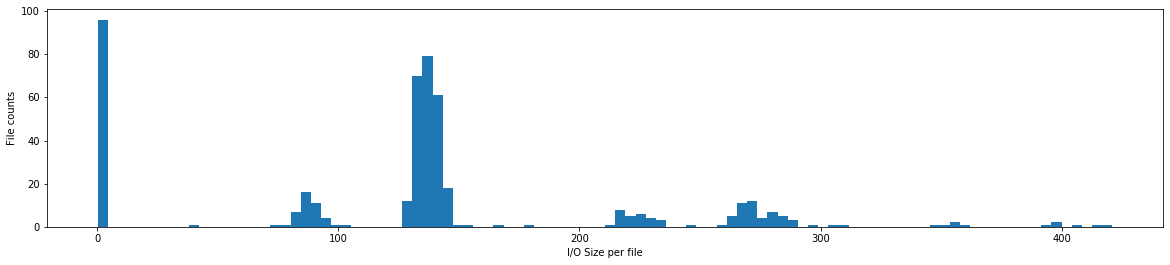

In [15]:
filename_series = []
size_series = []
for file in df['Filename'].unique():
    filename_series.append(os.path.splitext(ntpath.basename(file))[0][6:11])
    size_series.append(float(profile.GetIOSize(filepath=file))/1024.0/1024.0)

zipped_lists = zip(filename_series, size_series)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
filename_series, size_series = [ list(tuple) for tuple in  tuples]



plt.figure(figsize=(20,4))
size_series = np.array(size_series)
plt.hist(size_series,bins = 100)
plt.xlabel("I/O Size per file")
plt.ylabel("File counts")
plt.show()
    
# points_x = 30
# for i in range(math.ceil(float(len(size_series))/points_x)):
#     start = i * points_x
#     end = (i+1) * points_x
#     plt.figure(figsize=(20,4))
#     plt.grid()
#     plt.plot(filename_series[start:end], size_series[start:end]);
#     plt.show()

In [16]:
for rank in df['Rank'].unique():
    print("I/O performed by rank {}: {:0.2f} MB".format(rank, float(profile.GetIOSize(rank=rank))/1024.0/1024.0))

I/O performed by rank 0: 7737.93 MB
I/O performed by rank 1: 7767.65 MB
I/O performed by rank 2: 7669.87 MB
I/O performed by rank 3: 7731.88 MB
I/O performed by rank 4: 7769.73 MB
I/O performed by rank 5: 7722.43 MB
I/O performed by rank 6: 7714.84 MB
I/O performed by rank 7: 7756.16 MB


In [17]:
print("Average Size of dataset {:0.2f} MB".format(np.mean(list(profile.GetFileSizes().values()))/1024.0/1024.0))

Average Size of dataset 134.58 MB


### How application access data over time.

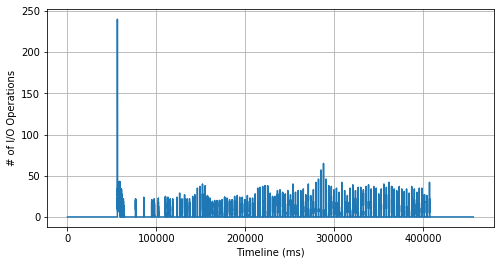

In [43]:
tl = profile.CreateIOTimeline(is_print=False)
plt.figure(figsize=(8,4))
plt.xlabel("Timeline (ms)")
plt.ylabel("# of I/O Operations")
plt.grid()
plt.plot(tl['time_step'], tl['operation_count']);

# plt.figure(figsize=(20,4))
plt.grid()
plt.plot(tl['time_step'], tl['io_bytes']);

### How files are accessed over the duration of the Job.

In [20]:
filename_series = []
operation_series = []
for file in df['Filename'].unique():
    tl = profile.CreateIOTimeline(filepath=file,is_print=False)
    filename_series.append(os.path.splitext(ntpath.basename(file))[0][6:11])
    operation_series.append(tl['operation_count'].sum())

plt.figure(figsize=(20,4))
operation_series = np.array(operation_series)
plt.hist(operation_series,bins = 100);
plt.show()

[============================================================] 100.0% 1661 of 1661 Creating Timeline 
[============================================================] 100.0% 1691 of 1691 Creating Timeline 
[============================================================] 100.0% 1092 of 1092 Creating Timeline 
[============================================================] 100.0% 1430 of 1430 Creating Timeline 
[============================================================] 100.0% 1146 of 1146 Creating Timeline 
[============================================================] 100.0% 590 of 590 Creating Timeline 
[============================================================] 100.0% 528 of 528 Creating Timeline 
[============================================================] 100.0% 564 of 564 Creating Timeline 
[============================================================] 100.0% 532 of 532 Creating Timeline 
[============================================================] 100.0% 1038 of 1038 Creatin

KeyboardInterrupt: 

### Show how each file is accessed by each rank.

[============================================================] 100.0% 31078 of 31078 Creating Timeline 
[============================================================] 100.0% 31194 of 31194 Creating Timeline 


SystemError: <built-in method item of numpy.ndarray object at 0x7fe7b92b2c10> returned a result with an error set

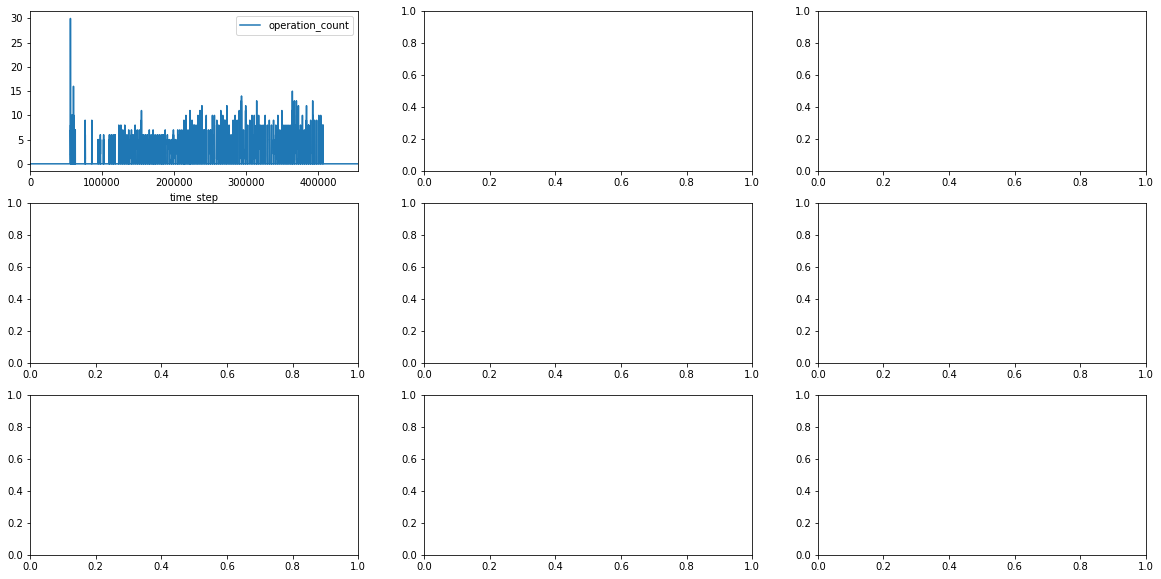

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
for rank in df['Rank'].unique():
    x = int(rank/3)
    y = rank%3
    tl = profile.CreateIOTimeline(rank=rank)
    tl.plot(x='time_step',y='operation_count', title=rank, ax=axs[x][y])


### Data Transfer Size distribution within the application

Text(0.5, 0, 'Transfer Size in bytes')

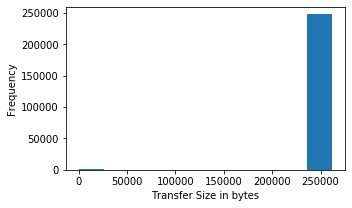

In [39]:
request_df = profile.GetIORequestDistribution()
df['Length'].plot(kind='hist', figsize=(5, 3));
plt.xlabel("Transfer Size in bytes")

### Data Transfer Size distribution for each file.

In [24]:
filename_series = []
request_mean = []
for file in df['Filename'].unique():
    tl = profile.GetIORequestDistribution(filepath=file)
    request_mean.append(tl.mean())

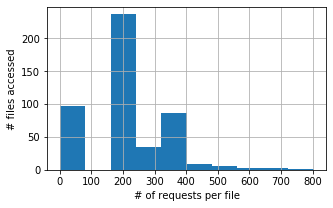

In [45]:
plt.figure(figsize=(5,3))
request_mean = np.array(request_mean)
plt.hist(request_mean,bins = 10);
plt.ylabel("# files accessed")
plt.xlabel("# of requests per file")
plt.grid()
plt.show()

### Data Transfer Sizes per Rank

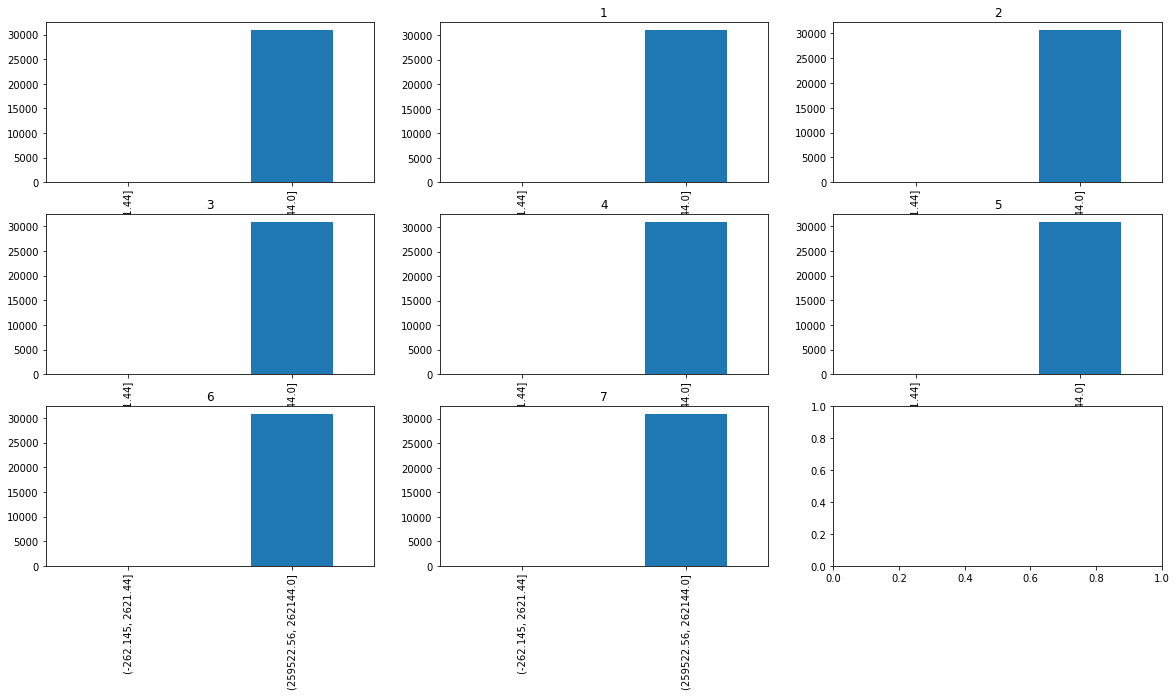

In [29]:
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
for rank in df['Rank'].unique():
    x = int(rank/3)
    y = rank%3
    tl = profile.GetIORequestDistribution(rank=rank)
    tl.plot(kind='bar', title=rank, ax=axs[x][y])

### File summary of each file accessed by the Application

In [30]:
pp = pprint.PrettyPrinter(indent=1)
count =1
for file in df['Filename'].unique():
    if 'h5' in file:
        pp.pprint(profile.GetFileSummary(file,ext='h5'))
    else:
        if count == 1:
            count+=1
            pp.pprint(profile.GetFileSummary(file,ext='tfrecord',tf_record_features={
      'image/encoded': tf.io.FixedLenFeature((), dtype=tf.string, default_value=''),
      'image/source_id': tf.io.FixedLenFeature((), tf.string, default_value=''),
      'image/height': tf.io.FixedLenFeature((), tf.int64, default_value=1),
      'image/width': tf.io.FixedLenFeature((), tf.int64, default_value=1),
      'image/object/bbox/xmin': tf.io.VarLenFeature(dtype=tf.float32),
      'image/object/bbox/ymin': tf.io.VarLenFeature(dtype=tf.float32),
      'image/object/bbox/xmax': tf.io.VarLenFeature(dtype=tf.float32),
      'image/object/bbox/ymax': tf.io.VarLenFeature(dtype=tf.float32),
      'image/object/class/label': tf.io.VarLenFeature(dtype=tf.int64),
      'image/object/class/text': tf.io.FixedLenFeature((), dtype=tf.string, default_value=''),
      'image/colorspace': tf.io.FixedLenFeature((), tf.string, default_value=''),
      'image/channels': tf.io.FixedLenFeature((), tf.int64, default_value=1),
      'image/format': tf.io.FixedLenFeature((), tf.string, default_value=''),
      'image/filename': tf.io.FixedLenFeature((), tf.string, default_value='')
  }))

{'ext': 'tfrecord',
 'filename': 'train-00125-of-01024',
 'io_size': 433075841,
 'io_time': 0.3387500000000543,
 'path': '/projects/datascience/rzamora/data/imagenet/count.48.size.8m/train-00125-of-01024',
 'size': 144183851,
 'special': <ParallelMapDataset shapes: {image/object/bbox/xmax: (None,), image/object/bbox/xmin: (None,), image/object/bbox/ymax: (None,), image/object/bbox/ymin: (None,), image/object/class/label: (None,), image/channels: (), image/colorspace: (), image/encoded: (), image/filename: (), image/format: (), image/height: (), image/object/class/text: (), image/source_id: (), image/width: ()}, types: {image/object/bbox/xmax: tf.float32, image/object/bbox/xmin: tf.float32, image/object/bbox/ymax: tf.float32, image/object/bbox/ymin: tf.float32, image/object/class/label: tf.int64, image/channels: tf.int64, image/colorspace: tf.string, image/encoded: tf.string, image/filename: tf.string, image/format: tf.string, image/height: tf.int64, image/object/class/text: tf.string, 

In [33]:
import random
print(random.randint(0,2000))

1731
